In [1]:
# Model Understanding with Captum
# Captum is a model interpretability library for PyTorch, with "state of the art libraries"
# https://captum.ai/

# Captum's approach to interpretability is via ""attributions"
# Attributions are the contribution of each input feature to the output of the mode
# Feature Attribution
# Layer Attribution
# Neuron Attribution

# Each of these attributions has multiple attribution algorithms associated with it

# Gradient based algorithms calculate the backward gradients of a model's
# output, layer output, or neuron activation wrt input
# e.g. Integrated Gradients, Layer Gradient * Activation, and Neuron Conductance 

# Pertubation-based algorithms examine the changes in the output of a model, layer, or neuron
# wrt small changes in the input. 
# These small changes can be random or directed. 
# Occlusion, Feature Ablation, and Feature Permutation are all pertubation-based algorithms
# This is probably the closest to a marginal effect we talk about in econometrics

# Captum also has a number of visualization tools to help interpret the attributions
# This is marketed as Captum Insights


In [ ]:
# Preliminary
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models

import captum
from captum.attr import IntegratedGradients, Occlusion, LayerGradCam, LayerAttribution
from captum.attr import visualization as viz

import os, sys
import json

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap


In [5]:
# Load in pre-trained ResNet
model = models.resnet18(weights='IMAGENET1K_V1')
model = model.eval()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/zeyuz/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:03<00:00, 13.6MB/s]


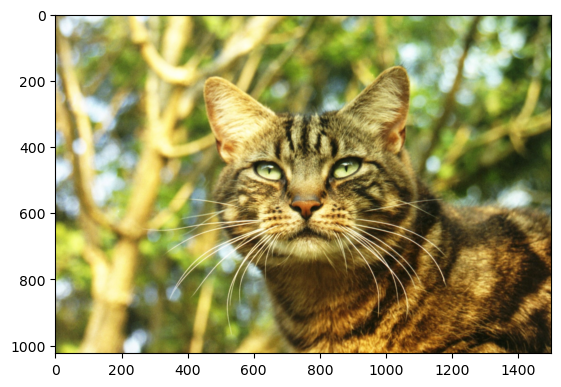

In [7]:
test_img = Image.open('../img/cat.jpg')
test_img_data = np.asarray(test_img)
plt.imshow(test_img_data)
plt.show()

In [13]:
# ResNet requires images to be 224 x 224 tricolor (RGB)
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

# standard imagenet normalisation
transform_normalize = transforms.Normalize(
    mean = [0.485, 0.456, 0.406], 
    std = [0.229, 0.224, 0.225]
)

transformed_img = transform(test_img)
# unsqueeze adds a dummy batch dimension
# unsqueeze adds a dimension of size one at the specified position
input_img = transform_normalize(transformed_img).unsqueeze(0)
# see what unsqueeze does
print(input_img.shape)
print(input_img)

labels_path = "../img/imagenet_class_index.json"
with open(labels_path) as json_data:
    idx_to_labels = json.load(json_data)


torch.Size([1, 3, 224, 224])
tensor([[[[ 2.1975,  2.2147,  2.1804,  ...,  0.9646,  0.8447,  0.7248],
          [ 2.1975,  2.2147,  2.1975,  ...,  0.8961,  0.7419,  0.5536],
          [ 2.1975,  2.2147,  2.1975,  ...,  0.8618,  0.7077,  0.4851],
          ...,
          [ 2.0605,  2.0434,  1.9235,  ..., -0.7308, -0.4226, -0.1999],
          [ 2.0263,  1.9578,  1.7694,  ..., -0.7822, -0.6281, -0.2342],
          [ 1.9578,  1.8379,  1.5639,  ..., -0.4911, -0.2684, -0.1486]],

         [[ 2.2710,  2.3235,  2.3060,  ...,  1.5007,  1.3256,  1.1856],
          [ 2.2710,  2.3235,  2.3235,  ...,  1.4307,  1.2556,  1.0280],
          [ 2.2360,  2.3060,  2.3235,  ...,  1.3957,  1.2206,  0.9580],
          ...,
          [ 2.3235,  2.3235,  2.2710,  ..., -1.0203, -0.8102, -0.6877],
          [ 2.3060,  2.2885,  2.2185,  ..., -1.2304, -1.1253, -0.8277],
          [ 2.2535,  2.2185,  2.0609,  ..., -1.0028, -0.8102, -0.7402]],

         [[ 1.3328,  2.0823,  2.3437,  ...,  0.8274,  0.6356,  0.4439],
 

In [ ]:
# Predict the image
output = model(input_img)
output = F.softmax(output, dim = 1)
prediction_score, pred_label_idx = torch.topk(output, 1)
# _ for modify in place
pred_label_idx.squeeze_()
predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
print(f"Predicted Label: {predicted_label}")
print(f"Prediction Score: {prediction_score.squeeze().item()}")

# Confirm that Model thinks it's a tabby cat
# In what follows, we investigate why the model thinks so

Predicted Label: tabby
Prediction Score: 0.5688223838806152


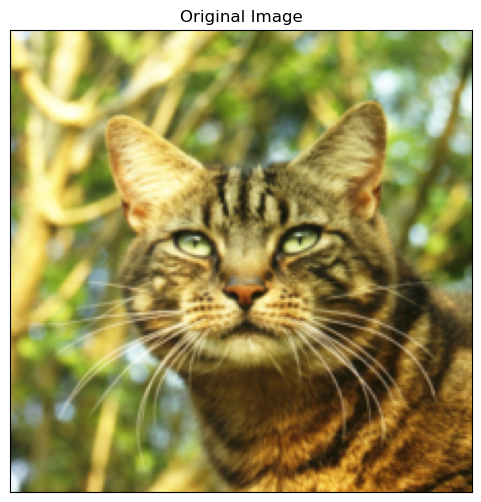

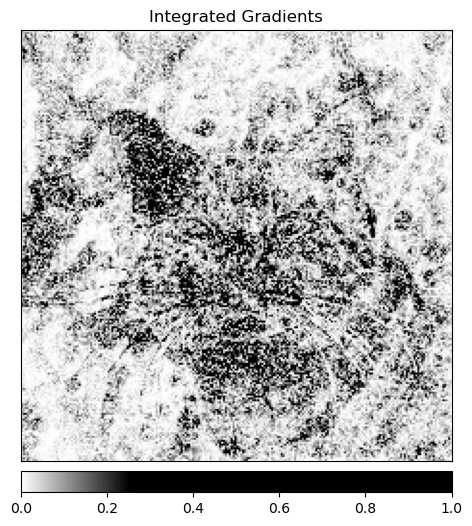

(<Figure size 600x600 with 2 Axes>,
 <Axes: title={'center': 'Integrated Gradients'}>)

In [ ]:
# Integrated Gradients
# These assign an importance score to each input by approximating the integral of the 
# gradients of the model's output wrt the inputs

# In this case, we take a specific element of the output vector
# (the one corresponding to the confidence score in predicted category)
# and use integrated gradients to see which parts of the pixel contributed to this outcome

# We can then visualize the importance map from Captum

# Gradient based attribution methods can be computationally expensive
# and is somewhat akin to directly calculating the marginal effect of a feature

# intialize the IntegratedGradients object
integrated_gradients = IntegratedGradients(model)

# Ask the algorithm to attribute our output target to 
attributions_ig = integrated_gradients.attribute(input_img, target = pred_label_idx, n_steps = 20)

# Show the original image for comparison
_ = viz.visualize_image_attr(
    None, 
    np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1, 2, 0)), 
    method = 'original_image', title = 'Original Image')

# create a custom colormap
default_cmap = LinearSegmentedColormap.from_list(
    'custom blue',
    [(0, '#ffffff'),
    (0.25, '#000000'),
    (1, '#000000')],
    N = 256
)

_ = viz.visualize_image_attr(
    np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    method = 'heat_map',
    cmap = default_cmap,
    show_colorbar = True,
    title = 'Integrated Gradients'
)


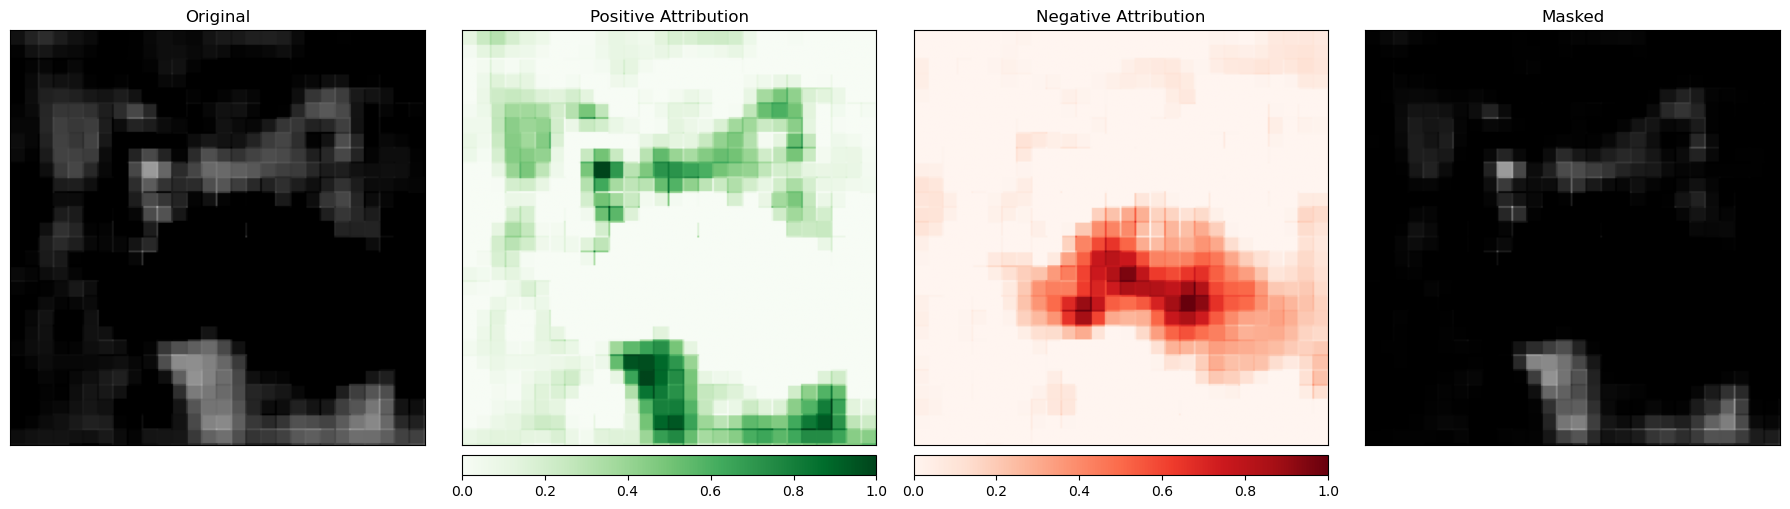

In [26]:
# Occlusion
# Occlusion on the other hand is a pertubation-based attribution method, and tries to 
# understand the importance of each input by occluding (pertubing) a specific part of the input
# and observing the change in the model's output

occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(
    input_img, 
    sliding_window_shapes = (3, 15, 15),
    strides = (3, 8, 8),
    target = pred_label_idx,
    baselines = 0
)

_ = viz.visualize_image_attr_multiple(
    np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1, 2, 0)), 
    ["original_image", "heat_map", "heat_map", "masked_image"], 
    ["all", "positive", "negative", "positive"], 
    show_colorbar = True, 
    titles = ["Original", "Positive Attribution", "Negative Attribution", "Masked"],
    fig_size = (18, 6)
)

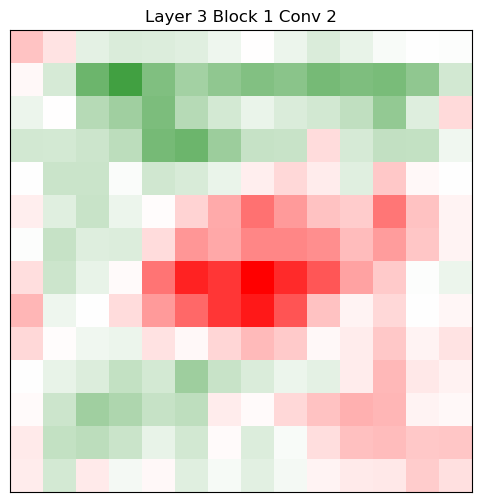

In [27]:
# Layer GradCAM
# Layer Attribution allows you to attribute the activity of hidden layers to 
# the features of the input
# This allows us some insight into what the convolution networks are doing

# GradCAM is one specific algorithm for Layer Attribution, esp suited for CNNs
# computes the gradients of the target output wrt the given layer
# averages for each output channel, and multiplies the average gradient for each channel 
# by the layer activations
# final results are summed up over all channels. 

layer_gradcam = LayerGradCam(model, model.layer3[1].conv2)
attributions_lgc = layer_gradcam.attribute(
    input_img, target = pred_label_idx
)

_ = viz.visualize_image_attr(
    attributions_lgc[0].cpu().permute(1, 2, 0).detach().numpy(), 
    sign = "all", 
    title = "Layer 3 Block 1 Conv 2"
)


torch.Size([1, 1, 14, 14])
torch.Size([1, 1, 224, 224])
torch.Size([1, 3, 224, 224])


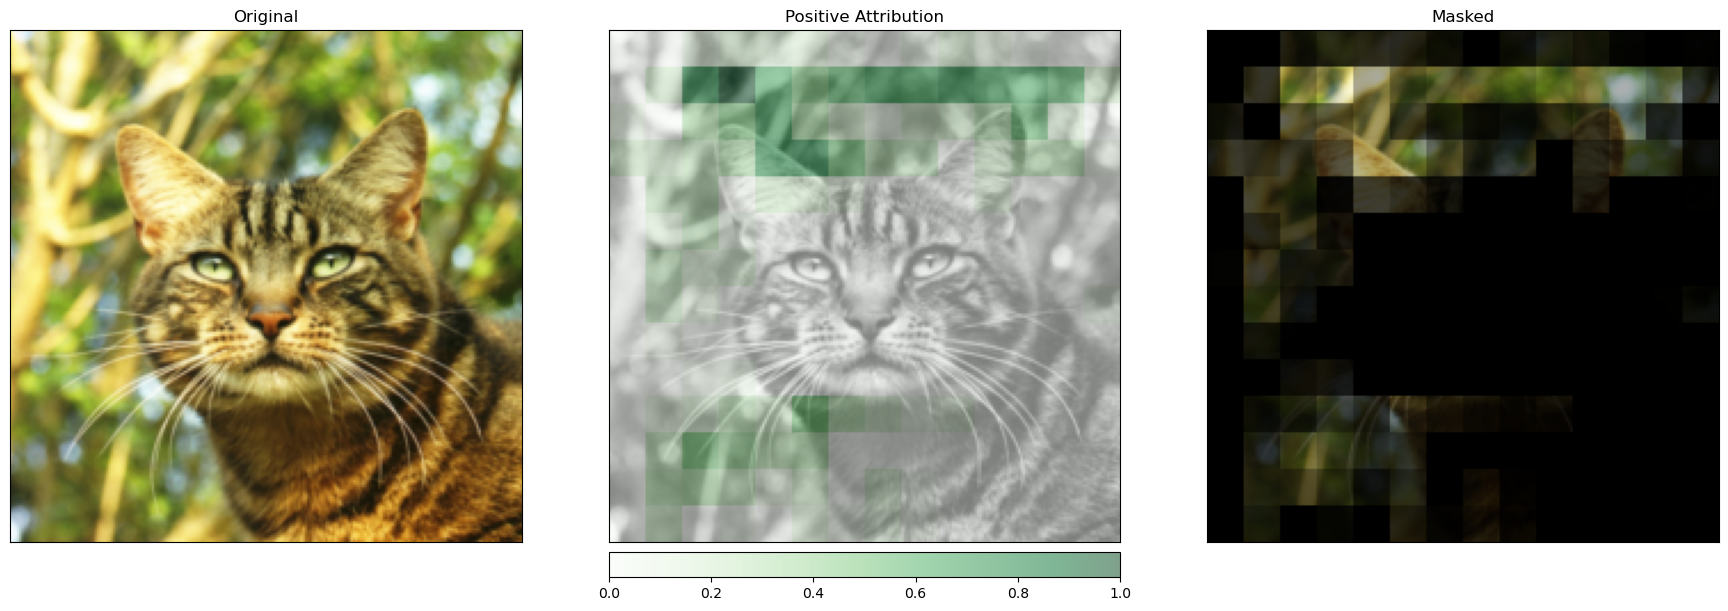

In [29]:
# Then we can use the interpolate() method in LayAttribution to upsample this 
# to compare with the original image

upsamp_attr_lgc = LayerAttribution.interpolate(
    attributions_lgc, input_img.shape[2:]
)

print(attributions_lgc.shape)
print(upsamp_attr_lgc.shape)
print(input_img.shape)

_ = viz.visualize_image_attr_multiple(
    upsamp_attr_lgc[0].cpu().permute(1, 2, 0).detach().numpy(), 
    transformed_img.permute(1, 2, 0).numpy(), 
    ["original_image", "blended_heat_map", "masked_image"], 
    ["all", "positive", "positive"],
    show_colorbar = True, 
    titles = ["Original", "Positive Attribution", "Masked"], 
    fig_size = (18, 6)
)

In [ ]:
# Captum Insights

# Captum Insights is a high-level API that allows you to visualize attributions
# in a more interactive way

imgs = ["../img/cat.jpg", "../img/teapot.jpg", "../img/trilobite.jpg"]

for img in imgs:
    # import image, and do some pre-processing
    img = Image.open(img)
    transformed_img = transform(img)
    input_img = transform_normalize(transformed_img).unsqueeze(0)
    
    # predict
    output = model(input_img)
    output = F.softmax(output, dim = 1)
    prediction_score, pred_label_idx = torch.topk(output, 1)
    pred_label_idx.squeeze_()
    predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
    print(f"Predicted Label: {predicted_label}")
    print(f"Prediction Score: {prediction_score.squeeze().item()}")

# loop through the images and generate predictions
# Looks like the model is correct in all of them


Predicted Label: tabby
Prediction Score: 0.5688223838806152
Predicted Label: teapot
Prediction Score: 0.9914799928665161
Predicted Label: trilobite
Prediction Score: 0.9999061822891235


In [ ]:
# AttributionVisuailizer is configured with the following arguments
# array of models to be examined (just one in our case)
# scoring function
# ordered human-readable list of classes
# list of features to look for, i.e. ImageFeature
# dataset

# preliminary
from captum.insights import AttributionVisualizer, Batch
from captum.insights.attr_vis.features import ImageFeature
import flask

# baseline is all zeros input, could be different depending on context of data
def baseline_func(input):
    return input * 0

# merging our image transforms from above
def full_img_transform(input):  
    input = Image.open(input)
    input = transform(input)
    input = transform_normalize(input)
    input = input.unsqueeze(0)
    return input

input_imgs = torch.cat(list(map(lambda i: full_img_transform(i), imgs)), 0)

visualizer = AttributionVisualizer(
    models = [model], 
    score_func = lambda o: torch.nn.functional.softmax(o, 1),
    classes = list(map(lambda k: idx_to_labels[k][1], idx_to_labels.keys())), 
    features = [
        ImageFeature(
            "Photo", 
            baseline_transforms = [baseline_func], 
            input_transforms=[], 
        )
    ], 
    dataset = [Batch(input_imgs, labels = [282, 849, 69])]
)

# Note that these simply sets the atrtibutes to the visualizer, which doesn't take very 
# long


In [ ]:
# actually rendering the visualizer is a bit more involved and takes a few minutes, usually

visualizer.render()